In [2]:
num_epochs_base = 700
lr = 0.001
num_hidden = 16

Epoch 1, Loss: 1.9454, Train Acc: 0.1571
Val Acc: 0.2380
Epoch 2, Loss: 1.9444, Train Acc: 0.1929
Val Acc: 0.2420
Epoch 3, Loss: 1.9436, Train Acc: 0.2429
Val Acc: 0.2780
Epoch 4, Loss: 1.9423, Train Acc: 0.3357
Val Acc: 0.2980
Epoch 5, Loss: 1.9414, Train Acc: 0.3071
Val Acc: 0.3100
Epoch 6, Loss: 1.9401, Train Acc: 0.4000
Val Acc: 0.3360
Epoch 7, Loss: 1.9402, Train Acc: 0.4000
Val Acc: 0.3760
Epoch 8, Loss: 1.9385, Train Acc: 0.4714
Val Acc: 0.4040
Epoch 9, Loss: 1.9374, Train Acc: 0.4643
Val Acc: 0.4500
Epoch 10, Loss: 1.9362, Train Acc: 0.4929
Val Acc: 0.4880
Epoch 11, Loss: 1.9352, Train Acc: 0.5500
Val Acc: 0.5220
Epoch 12, Loss: 1.9335, Train Acc: 0.6071
Val Acc: 0.5520
Epoch 13, Loss: 1.9325, Train Acc: 0.6214
Val Acc: 0.5740
Epoch 14, Loss: 1.9313, Train Acc: 0.6429
Val Acc: 0.5880
Epoch 15, Loss: 1.9312, Train Acc: 0.5714
Val Acc: 0.6100
Epoch 16, Loss: 1.9266, Train Acc: 0.7786
Val Acc: 0.6180
Epoch 17, Loss: 1.9261, Train Acc: 0.6786
Val Acc: 0.6300
Epoch 18, Loss: 1.9257,

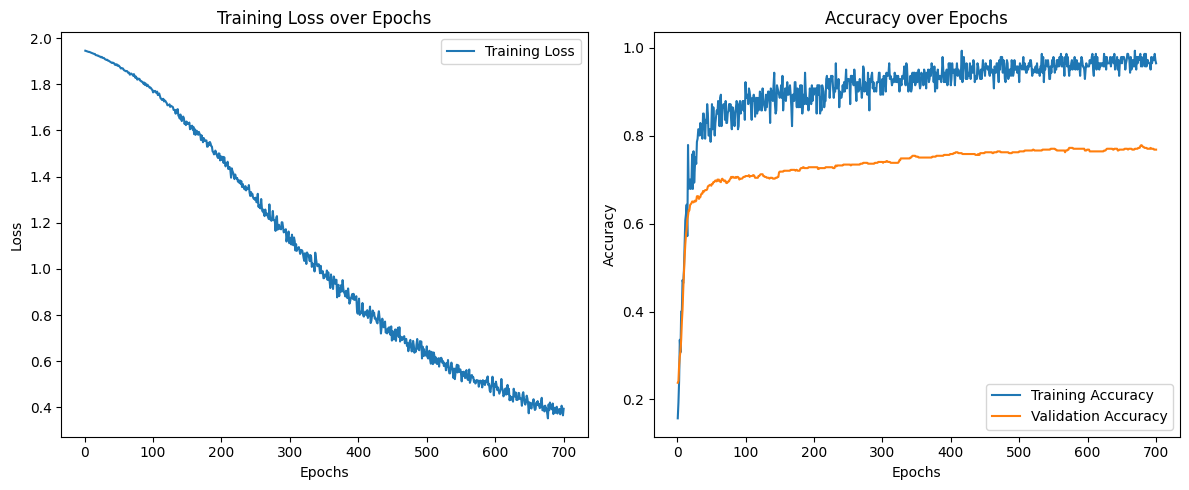

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the Cora dataset
path = './data/Cora'
transform = T.Compose([T.NormalizeFeatures()])
dataset = Planetoid(path, name='Cora', transform=transform)[0]

# Number of features and classes for the Cora dataset
num_features = 1433
num_classes = 7

# Initialize the DataLoader
train_loader = DataLoader([dataset], batch_size=1, shuffle=True)
val_loader = DataLoader([dataset], batch_size=1, shuffle=False)

# Training and validation functions
def train(model, optimizer, train_loader, device, epoch, distillate=False, teacher=None):
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[dataset.train_mask], data.y[dataset.train_mask])
        ##############################################################################################
        if distillate and teacher is not None:
            with torch.no_grad():
                teacher_out = teacher(data)
            loss += F.mse_loss(out[dataset.train_mask], teacher_out[dataset.train_mask])
        ##############################################################################################
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = out[dataset.train_mask].argmax(dim=1)
        correct += pred.eq(data.y[dataset.train_mask]).sum().item()
    train_acc = correct / dataset.train_mask.sum().item()
    print(f'Epoch {epoch}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}')
    return total_loss / len(train_loader.dataset), train_acc

def validate(model, val_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            pred = out[dataset.val_mask].argmax(dim=1)
            correct += pred.eq(data.y[dataset.val_mask]).sum().item()
    val_acc = correct / dataset.val_mask.sum().item()
    print(f'Val Acc: {val_acc:.4f}')
    return val_acc

# Initialize the model and optimizer for Stage 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = GCN(num_features, num_hidden, num_classes).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr, weight_decay=1e-5)

# Training the base model for 200 epochs
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = range(1, num_epochs_base+1)

for epoch in epochs:
    loss, train_acc = train(base_model, optimizer, train_loader, device, epoch)
    val_acc = validate(base_model, val_loader, device)
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1, Loss: 30.8337, Train Acc: 0.6500
Val Acc: 0.4240
Epoch 2, Loss: 27.1771, Train Acc: 0.5571
Val Acc: 0.4240
Epoch 3, Loss: 25.9653, Train Acc: 0.5571
Val Acc: 0.4260
Epoch 4, Loss: 26.6916, Train Acc: 0.5857
Val Acc: 0.4260
Epoch 5, Loss: 31.6027, Train Acc: 0.6143
Val Acc: 0.4280
Epoch 6, Loss: 29.4992, Train Acc: 0.6643
Val Acc: 0.4280
Epoch 7, Loss: 30.4191, Train Acc: 0.5286
Val Acc: 0.4300
Epoch 8, Loss: 28.0342, Train Acc: 0.5929
Val Acc: 0.4300
Epoch 9, Loss: 28.3428, Train Acc: 0.5929
Val Acc: 0.4300
Epoch 10, Loss: 28.5479, Train Acc: 0.5714
Val Acc: 0.4300
Epoch 11, Loss: 29.0754, Train Acc: 0.5500
Val Acc: 0.4300
Epoch 12, Loss: 27.4505, Train Acc: 0.6643
Val Acc: 0.4320
Epoch 13, Loss: 27.3836, Train Acc: 0.6214
Val Acc: 0.4320
Epoch 14, Loss: 27.9537, Train Acc: 0.5929
Val Acc: 0.4320
Epoch 15, Loss: 27.6675, Train Acc: 0.5857
Val Acc: 0.4320
Epoch 16, Loss: 30.0180, Train Acc: 0.5786
Val Acc: 0.4320
Epoch 17, Loss: 25.8055, Train Acc: 0.5429
Val Acc: 0.4340
Epoch 

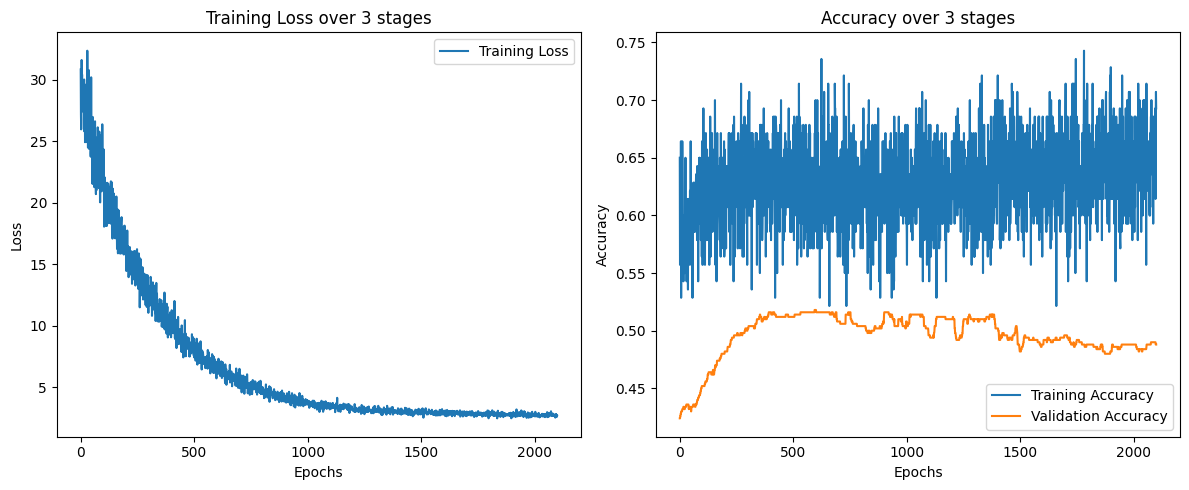

In [5]:
import matplotlib.pyplot as plt

train_losses3 = []
train_accuracies3 = []
val_accuracies3 = []

# Define custom GCNConv layer to handle latent weights
class BinaryGCNConv(GCNConv):
    def __init__(self, in_channels, out_channels):
        super(BinaryGCNConv, self).__init__(in_channels, out_channels)
        self.latent_weight = nn.Parameter(torch.empty(self.out_channels, self.in_channels))
        nn.init.xavier_uniform_(self.latent_weight)  # Initialize weights explicitly

    def forward(self, x, edge_index, edge_weight=None):
        weight_bin = (self.latent_weight > 0).float() * 2 - 1
        self.weight = nn.Parameter(weight_bin)  # Assign the binary weights to self.weight
        return super(BinaryGCNConv, self).forward(x, edge_index, edge_weight)  # Call the parent forward method

    def message(self, x_j, edge_weight):
        if edge_weight is None:
            return x_j
        else:
            return edge_weight.view(-1, 1) * x_j


# Define the custom GCN model with binary weights
class BinaryGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BinaryGCN, self).__init__()
        self.conv1 = BinaryGCNConv(in_channels, hidden_channels)
        self.conv2 = BinaryGCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = (x > 0).float() * 2 - 1  # Binary activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)





# Initialize the student model for Stage 3
student_stage3 = BinaryGCN(num_features, num_hidden, num_classes).to(device)

# Load the state dictionary from student_stage2 (default weights)
state_dict = base_model.state_dict()
student_stage3.load_state_dict(state_dict, strict=False)  # Allow mismatched keys

# Manually update latent_weight for each BinaryGCNConv layer
with torch.no_grad():
    student_stage3.conv1.latent_weight.copy_(base_model.conv1.lin.weight.clone().detach())
    student_stage3.conv2.latent_weight.copy_(base_model.conv2.lin.weight.clone().detach())






optimizer_stage3 = torch.optim.Adam(student_stage3.parameters(), lr=lr, weight_decay=0)  # No weight decay

# Training the student model for Stage 3
for epoch in range(1, 3 * num_epochs_base + 1):
    loss, train_acc = train(student_stage3, optimizer_stage3, train_loader, device, epoch, distillate=True, teacher=base_model)
    val_acc = validate(student_stage3, val_loader, device)
    train_losses3.append(loss)
    train_accuracies3.append(train_acc)
    val_accuracies3.append(val_acc)





# Combine all epochs into one list
total_epochs = num_epochs_base

# Ensure lengths of the lists match
train_losses = train_losses3
train_accuracies = train_accuracies3
val_accuracies = val_accuracies3

plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over 3 stages')
plt.legend()

# Plot the accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over 3 stages')
plt.legend()

plt.tight_layout()
plt.show()
